In [1]:
import tensorflow as tf
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import sys
sys.path.insert(1,'c:/Users/h2pro/Programming')
import StockPull
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import seaborn as sns
from pandas.tseries.holiday import USFederalHolidayCalendar

from pandas.tseries.offsets import CustomBusinessDay
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
# import keras
# from keras.models import Sequential
# from keras.layers import LSTM, Dense, Dropout

                          Date       Price     Volume
0    2018-01-24 00:00:00-05:00   41.416435  204420400
1    2018-01-25 00:00:00-05:00   40.677113  166116000
2    2018-01-26 00:00:00-05:00   40.772202  156572000
3    2018-01-29 00:00:00-05:00   39.928280  202561600
4    2018-01-30 00:00:00-05:00   39.692928  184192800
...                        ...         ...        ...
1253 2023-01-17 00:00:00-05:00  135.940002   63646600
1254 2023-01-18 00:00:00-05:00  135.210007   69672800
1255 2023-01-19 00:00:00-05:00  135.270004   58280400
1256 2023-01-20 00:00:00-05:00  137.869995   79972200
1257 2023-01-23 00:00:00-05:00  141.110001   79728676

[1258 rows x 3 columns]


ImportError: cannot import name 'keras' from 'tensorflow' (unknown location)

In [10]:
#load data
company = 'MSFT'
start = dt.datetime(2012,1,1)
end = dt.datetime(2022,1,1)

data = StockPull.analysisout(company)
df = data

In [11]:
#Separate dates for future plotting
train_dates = pd.to_datetime(df['Date'])
print(train_dates.tail(15)) #Check last few dates. 

#Variables for training
cols = list(df)[1:3]
#New dataframe with only training data - 5 columns
df_for_training = df[cols].astype(float)
# print(train_data)
print(df_for_training)

1243   2022-12-30 00:00:00-05:00
1244   2023-01-03 00:00:00-05:00
1245   2023-01-04 00:00:00-05:00
1246   2023-01-05 00:00:00-05:00
1247   2023-01-06 00:00:00-05:00
1248   2023-01-09 00:00:00-05:00
1249   2023-01-10 00:00:00-05:00
1250   2023-01-11 00:00:00-05:00
1251   2023-01-12 00:00:00-05:00
1252   2023-01-13 00:00:00-05:00
1253   2023-01-17 00:00:00-05:00
1254   2023-01-18 00:00:00-05:00
1255   2023-01-19 00:00:00-05:00
1256   2023-01-20 00:00:00-05:00
1257   2023-01-23 00:00:00-05:00
Name: Date, dtype: datetime64[ns, America/New_York]
           Price      Volume
0      86.468254  33277500.0
1      86.948532  26383200.0
2      88.577713  29172200.0
3      88.445854  31569900.0
4      87.334633  38635100.0
...          ...         ...
1253  240.350006  29831300.0
1254  235.809998  30028700.0
1255  231.929993  28623000.0
1256  240.220001  35323400.0
1257  242.580002  30346782.0

[1258 rows x 2 columns]


In [12]:
scaler = StandardScaler()
scaler = scaler.fit(df_for_training)
df_for_training_scaled = scaler.transform(df_for_training)

In [13]:
#Empty lists to be populated using formatted training data
trainX = []
trainY = []

n_future = 1   # Number of days we want to look into the future based on the past days.
n_past = 60  # Number of past days we want to use to predict the future.

#Reformat input data into a shape: (n_samples x timesteps x n_features)
#In my example, my df_for_training_scaled has a shape (12823, 5)
#12823 refers to the number of data points and 5 refers to the columns (multi-variables).
for i in range(n_past, len(df_for_training_scaled) - n_future +1):
    trainX.append(df_for_training_scaled[i - n_past:i, 0:df_for_training.shape[1]])
    trainY.append(df_for_training_scaled[i + n_future - 1:i + n_future, 0])

trainX, trainY = np.array(trainX), np.array(trainY)

print('trainX shape == {}.'.format(trainX.shape))
print('trainY shape == {}.'.format(trainY.shape))

trainX shape == (1198, 60, 2).
trainY shape == (1198, 1).


In [18]:
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(LSTM(32, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(trainY.shape[1]))

model.compile(optimizer='adam', loss='mse')
model.summary()


# fit the model
history = model.fit(trainX, trainY, epochs=25, batch_size=16, validation_split=0.1, verbose=1)

AttributeError: module 'tensorflow' has no attribute 'keras'

In [ ]:
#Predicting...
#Libraries that will help us extract only business days in the US.
#Otherwise our dates would be wrong when we look back (or forward).  
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay
us_bd = CustomBusinessDay(calendar=USFederalHolidayCalendar())
#Remember that we can only predict one day in future as our model needs 5 variables
#as inputs for prediction. We only have all 5 variables until the last day in our dataset.
n_past = 354
n_days_for_prediction=n_past+1  #let us predict past 15 days

predict_period_dates = pd.date_range(list(train_dates)[-n_past], periods=n_days_for_prediction, freq=us_bd).tolist()
print(predict_period_dates)

#Make prediction
prediction = model.predict(trainX[-n_days_for_prediction:]) #shape = (n, 1) where n is the n_days_for_prediction

[Timestamp('2021-07-16 00:00:00', freq='C'), Timestamp('2021-07-19 00:00:00', freq='C'), Timestamp('2021-07-20 00:00:00', freq='C'), Timestamp('2021-07-21 00:00:00', freq='C'), Timestamp('2021-07-22 00:00:00', freq='C'), Timestamp('2021-07-23 00:00:00', freq='C'), Timestamp('2021-07-26 00:00:00', freq='C'), Timestamp('2021-07-27 00:00:00', freq='C'), Timestamp('2021-07-28 00:00:00', freq='C'), Timestamp('2021-07-29 00:00:00', freq='C'), Timestamp('2021-07-30 00:00:00', freq='C'), Timestamp('2021-08-02 00:00:00', freq='C'), Timestamp('2021-08-03 00:00:00', freq='C'), Timestamp('2021-08-04 00:00:00', freq='C'), Timestamp('2021-08-05 00:00:00', freq='C'), Timestamp('2021-08-06 00:00:00', freq='C'), Timestamp('2021-08-09 00:00:00', freq='C'), Timestamp('2021-08-10 00:00:00', freq='C'), Timestamp('2021-08-11 00:00:00', freq='C'), Timestamp('2021-08-12 00:00:00', freq='C'), Timestamp('2021-08-13 00:00:00', freq='C'), Timestamp('2021-08-16 00:00:00', freq='C'), Timestamp('2021-08-17 00:00:00'

In [ ]:
#Perform inverse transformation to rescale back to original range
#Since we used 5 variables for transform, the inverse expects same dimensions
#Therefore, let us copy our values 5 times and discard them after inverse transform
prediction_copies = np.repeat(prediction, df_for_training.shape[1], axis=-1)
y_pred_future = scaler.inverse_transform(prediction_copies)[:,0]

In [ ]:
# Convert timestamp to date
forecast_dates = []
for time_i in predict_period_dates:
    forecast_dates.append(time_i.date())
    
df_forecast = pd.DataFrame({'Date':np.array(forecast_dates), 'Price':y_pred_future})
df_forecast['Date']=pd.to_datetime(df_forecast['Date'])


original = df[['Date', 'Price']]
original['Date']=pd.to_datetime(original['Date'])
original = original.loc[original['Date'] >= '2021-5-1']

C:\Users\h2pro\AppData\Local\Temp\ipykernel_31140\2600607734.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  original['Date']=pd.to_datetime(original['Date'])


In [ ]:
CompTable = pd.DataFrame(df)

NameError: name 'pd' is not defined

c:\Users\h2pro\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
c:\Users\h2pro\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


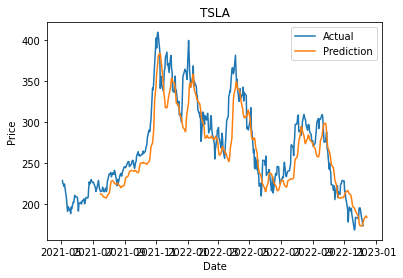

In [ ]:
sns.lineplot(original['Date'], original['Price'])
sns.lineplot(df_forecast['Date'], df_forecast['Price'])
sns.lineplot().set(title=company)
plt.legend(labels=["Actual","Prediction"])
